In [2]:
import torch
from torch import nn
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [35]:
class MultistepLSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=2, pred_steps=60, output_size=4):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.pred_steps = pred_steps
        self.output_size = output_size

    def forward(self, x):
        batch_size = x.size(0)
        device = x.device

        # LSTM encoder
        out, (h, c) = self.lstm(x)         # out: (B, T, H)
        input_step = x[:, -1:, :]          # last input timestep as seed (B, 1, input_size)

        outputs = []

        for _ in range(self.pred_steps):
            out_step, (h, c) = self.lstm(input_step, (h, c))     # out_step: (B, 1, H)
            pred = self.fc(out_step.squeeze(1))                  # (B, output_size)
            outputs.append(pred)

            input_step = pred.unsqueeze(1)                       # feedback as next input

        return torch.stack(outputs, dim=1)  # (B, pred_steps, output_size)


In [12]:
model = MultistepLSTM(input_size=4, hidden_size=64, num_layers=2, pred_steps=60, output_size=4)
model.total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {model.total_params}")

Total parameters: 66800


In [9]:
df = pd.read_csv('../../data/mock-metrics/2.csv', sep=';')
# df = df.drop(columns=['Hour', 'Weekday', 'HourBoost', 'WeekdayBoost', 'Noise', 'Spike'])
df = df.sort_values(by='Timestamp')
df = df.reset_index(drop=True)

df.head()

,Unnamed: 0,Timestamp,Request Count,CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s]
0,0,2024-01-01 00:00:00,269,4,12000,2754.456592,22.953805,1.398101e+06,567842.789948,1352.245297,836.310346,2127.726070,1871.889842
1,1,2024-01-01 00:01:00,257,4,12000,2602.820328,21.690169,1.398101e+06,564836.867672,1244.389358,768.297494,2073.162516,1764.664966
2,2,2024-01-01 00:02:00,272,4,12000,2696.023750,22.466865,1.398101e+06,550177.087138,1278.943182,785.985803,2151.081581,1930.686235
3,3,2024-01-01 00:03:00,290,4,12000,2981.465926,24.845549,1.398101e+06,573880.425889,1447.436519,858.255730,2331.242412,2071.459149
4,4,2024-01-01 00:04:00,255,4,12000,2457.594494,20.479954,1.398101e+06,654257.817225,1323.195885,764.555511,2045.168953,1818.377707


In [16]:
def calculate_network_load_score(total_network_throughput):
    # Các ngưỡng (KB/s)
    lowThreshold = 128
    mediumThreshold = 1280
    highThreshold = 6400
    maxThreshold = 12800

    score = 0.0
    if total_network_throughput <= lowThreshold:
        score = (total_network_throughput / lowThreshold) * 25
    elif total_network_throughput <= mediumThreshold:
        score = 25 + ((total_network_throughput - lowThreshold) / (mediumThreshold - lowThreshold)) * 25
    elif total_network_throughput <= highThreshold:
        score = 50 + ((total_network_throughput - mediumThreshold) / (highThreshold - mediumThreshold)) * 25
    elif total_network_throughput <= maxThreshold:
        score = 75 + ((total_network_throughput - highThreshold) / (maxThreshold - highThreshold)) * 25
    else:
        score = 100
    return min(max(score, 0), 100)


def calculate_disk_load_score(total_disk_throughput):
    # Các ngưỡng (KB/s)
    lowThreshold = 1024
    mediumThreshold = 10240
    highThreshold = 51200
    maxThreshold = 102400

    score = 0.0
    if total_disk_throughput <= lowThreshold:
        score = (total_disk_throughput / lowThreshold) * 25
    elif total_disk_throughput <= mediumThreshold:
        score = 25 + ((total_disk_throughput - lowThreshold) / (mediumThreshold - lowThreshold)) * 25
    elif total_disk_throughput <= highThreshold:
        score = 50 + ((total_disk_throughput - mediumThreshold) / (highThreshold - mediumThreshold)) * 25
    elif total_disk_throughput <= maxThreshold:
        score = 75 + ((total_disk_throughput - highThreshold) / (maxThreshold - highThreshold)) * 25
    else:
        score = 100
    return min(max(score, 0), 100)

In [25]:
from torch.utils.data import Dataset, DataLoader

class MultistepDataset(Dataset):
    def __init__(self, df, input_window=60, pred_steps=60):
        df['Total Network Throughput [KB/s]'] = df['Network received throughput [KB/s]'] + df['Network transmitted throughput [KB/s]']
        df['Total Disk Throughput [KB/s]'] = df['Disk read throughput [KB/s]'] + df['Disk write throughput [KB/s]']

        disk_throughput = df['Total Disk Throughput [KB/s]'].apply(calculate_disk_load_score)
        network_throughput = df['Total Network Throughput [KB/s]'].apply(calculate_network_load_score)

        memory_usage = df['Memory usage [KB]'] / df['Memory capacity provisioned [KB]']
        memory_usage = torch.tensor(memory_usage.values, dtype=torch.float32).unsqueeze(1)   # (N,1)
        cpu_usage = df['CPU usage [%]']
        cpu_usage = torch.tensor(cpu_usage.values, dtype=torch.float32).unsqueeze(1)         # (N,1)

        disk_throughput = torch.tensor(disk_throughput.values, dtype=torch.float32).unsqueeze(1)  # (N,1)
        network_throughput = torch.tensor(network_throughput.values, dtype=torch.float32).unsqueeze(1)  # (N,1)
        
        self.data = torch.cat([cpu_usage, memory_usage, network_throughput, disk_throughput], dim=1)  # shape (N, 4)
        
        self.input_window = input_window
        self.pred_steps = pred_steps

    def __len__(self):
        return len(self.data) - self.input_window - self.pred_steps

    def __getitem__(self, idx):
        # Lấy input sequence và target sequence
        x = self.data[idx : idx + self.input_window]   # (input_window, 4)
        y = self.data[idx + self.input_window : idx + self.input_window + self.pred_steps]  # (pred_steps, 4)
        return x, y


In [39]:
dataset.data[:60]

tensor([[22.9538,  0.4062, 63.2794, 28.1591],
        [21.6902,  0.4040, 62.4894, 27.6820],
        [22.4669,  0.3935, 63.6805, 27.8237],
        [24.8455,  0.4105, 65.2476, 28.4768],
        [20.4800,  0.4680, 62.6150, 27.8856],
        [21.0326,  0.4766, 62.7202, 27.7061],
        [23.7465,  0.4061, 65.0052, 28.5843],
        [23.0884,  0.4104, 63.5461, 28.4381],
        [20.3696,  0.3635, 61.9029, 27.6638],
        [22.6804,  0.2710, 63.4725, 28.1621],
        [20.7557,  0.3336, 62.4447, 27.6387],
        [20.6336,  0.4720, 61.9972, 27.5684],
        [22.1619,  0.3240, 63.0086, 27.8190],
        [18.3047,  0.4674, 59.8484, 26.8484],
        [18.2964,  0.4057, 60.2958, 27.2373],
        [21.8339,  0.3835, 61.8672, 27.7876],
        [19.7137,  0.3820, 61.1553, 27.6162],
        [21.2427,  0.3149, 62.9745, 27.8813],
        [19.7325,  0.3258, 61.6365, 27.6291],
        [18.7220,  0.4335, 61.0125, 27.3658],
        [24.4276,  0.3695, 65.1501, 28.6258],
        [21.3840,  0.4407, 62.7741

In [30]:
dataset = MultistepDataset(df, input_window=60, pred_steps=60)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MultistepLSTM(input_size=4, hidden_size=64, num_layers=2, pred_steps=60, output_size=4).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for x, y in dataloader:
        x = x.to(device)               # (B, input_window, 4)
        y = y.to(device)               # (B, pred_steps, 4)

        optimizer.zero_grad()
        output = model(x)              # (B, pred_steps, 4)

        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            loss = criterion(output, y)
            total_loss += loss.item()

    return total_loss / len(dataloader)


def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            output = model(x_batch)
            loss = criterion(output, y_batch)

            total_loss += loss.item() * x_batch.size(0)

    return total_loss / len(dataloader.dataset)

# Training loop ví dụ
num_epochs = 50

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, dataloader, optimizer, criterion, device)
    # val_loss = validate(model, dataloader, criterion, device)u

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}")

Epoch 1/20 - Train Loss: 1139.5484
Epoch 2/20 - Train Loss: 770.2291
Epoch 3/20 - Train Loss: 544.4654
Epoch 4/20 - Train Loss: 397.9058
Epoch 5/20 - Train Loss: 298.0414
Epoch 6/20 - Train Loss: 228.1205
Epoch 7/20 - Train Loss: 178.6796
Epoch 8/20 - Train Loss: 144.1977
Epoch 9/20 - Train Loss: 120.8220
Epoch 10/20 - Train Loss: 105.3018
Epoch 11/20 - Train Loss: 95.3429
Epoch 12/20 - Train Loss: 89.2979
Epoch 13/20 - Train Loss: 85.5573
Epoch 14/20 - Train Loss: 83.5066
Epoch 15/20 - Train Loss: 82.3333
Epoch 16/20 - Train Loss: 81.6482
Epoch 17/20 - Train Loss: 81.2746
Epoch 18/20 - Train Loss: 81.1458
Epoch 19/20 - Train Loss: 80.9847
Epoch 20/20 - Train Loss: 81.0215


In [48]:
def train_autoregressive(model, dataloader, optimizer, criterion, pred_steps):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        input_seq = x.clone()
        predictions = []
        for step in range(pred_steps):
            pred = model(input_seq)[:, -1:, :]  # chỉ lấy bước mới nhất
            predictions.append(pred)
            # ghép vào chuỗi đầu vào (autoregressive)
            input_seq = torch.cat((input_seq[:, 1:, :], pred), dim=1)
        predictions = torch.cat(predictions, dim=1)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

num_epochs = 20

for epoch in range(num_epochs):
    train_loss = train_autoregressive(model, dataloader, optimizer, criterion, 60)
    # val_loss = validate(model, dataloader, criterion, device)u

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}")

KeyboardInterrupt: 

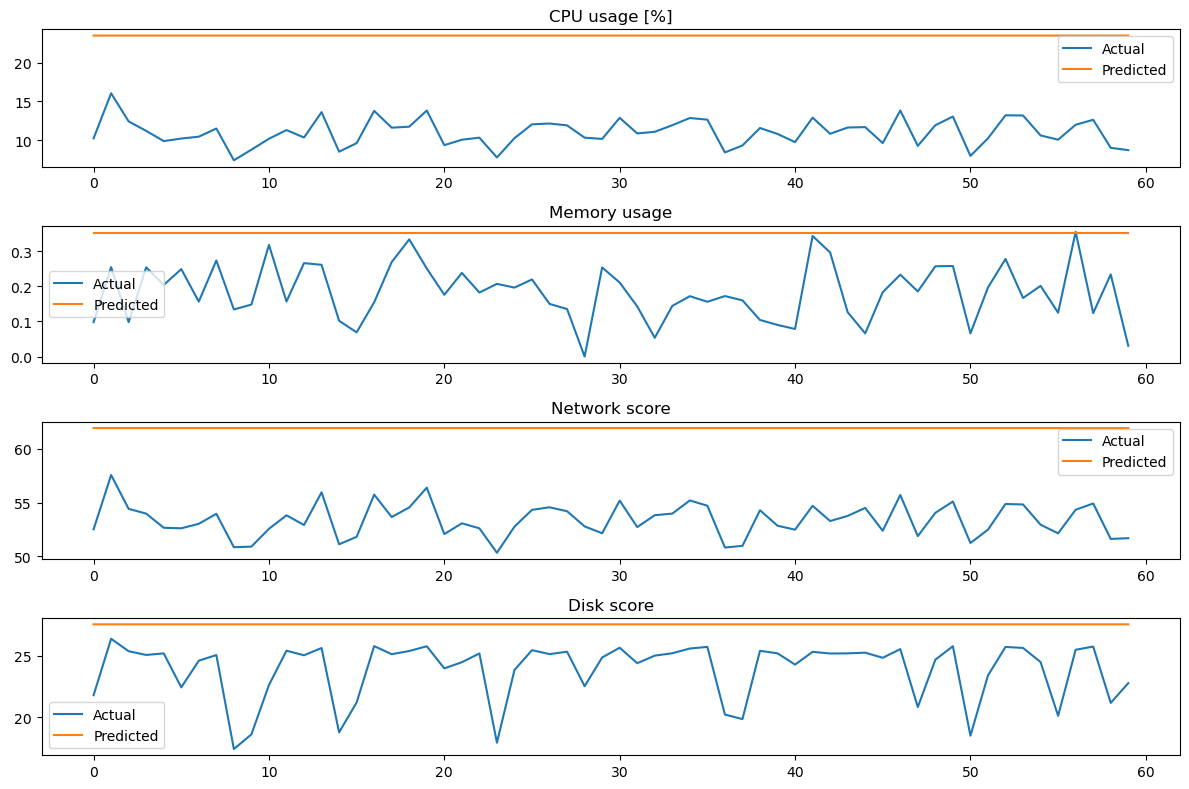

In [37]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for x, y in dataloader:
        output = model(x)  # (batch_size, pred_steps, output_size)
        break  # chỉ lấy batch đầu tiên để demo

# Chọn 1 sample trong batch
idx = 0
pred = output[idx].cpu().numpy()   # (pred_steps, output_size)
actual = y[idx].cpu().numpy()      # (pred_steps, output_size)

time_steps = range(pred.shape[0])

plt.figure(figsize=(12,8))
for i, metric in enumerate(['CPU usage [%]', 'Memory usage', 'Network score', 'Disk score']):
    plt.subplot(4, 1, i+1)
    plt.plot(time_steps, actual[:, i], label='Actual')
    plt.plot(time_steps, pred[:, i], label='Predicted')
    plt.title(metric)
    plt.legend()
plt.tight_layout()
plt.show()

In [47]:
x

tensor([[[12.0254,  0.2051, 54.4271, 25.4986],
         [ 8.8338,  0.2069, 51.6785, 20.5917],
         [10.0952,  0.1681, 52.5793, 22.6269],
         ...,
         [11.5959,  0.2034, 53.6528, 25.3727],
         [11.5797,  0.1052, 53.8219, 25.1963],
         [ 9.5308,  0.1891, 53.4111, 25.1835]],

        [[27.1322,  0.5408, 67.5510, 29.1072],
         [25.7622,  0.6228, 66.0457, 28.9817],
         [27.7885,  0.3970, 68.5474, 29.5782],
         ...,
         [29.0685,  0.4748, 68.7782, 29.8213],
         [26.3995,  0.4918, 67.3848, 29.5894],
         [31.8448,  0.5017, 72.1497, 30.6790]],

        [[17.7961,  0.2625, 59.7860, 26.9554],
         [18.4728,  0.3322, 60.1447, 26.8425],
         [15.3772,  0.2827, 57.8187, 26.0990],
         ...,
         [18.8849,  0.2346, 60.2999, 26.9862],
         [18.0568,  0.2316, 59.3437, 27.1675],
         [19.1371,  0.3103, 60.8788, 27.1772]],

        ...,

        [[13.7336,  0.1243, 55.8888, 25.7530],
         [15.0806,  0.3238, 56.4666, 26.0102]

In [42]:
pred

array([[23.486027  ,  0.353015  , 61.93878   , 27.565678  ],
       [23.486044  ,  0.35301504, 61.938816  , 27.56569   ],
       [23.486046  ,  0.3530151 , 61.938824  , 27.565691  ],
       [23.486046  ,  0.35301498, 61.938824  , 27.565691  ],
       [23.486046  ,  0.353015  , 61.938828  , 27.565691  ],
       [23.486046  ,  0.35301507, 61.93883   , 27.565691  ],
       [23.486046  ,  0.35301507, 61.93883   , 27.565691  ],
       [23.486046  ,  0.35301507, 61.93883   , 27.565691  ],
       [23.486046  ,  0.35301507, 61.93883   , 27.565691  ],
       [23.486046  ,  0.35301507, 61.93883   , 27.565691  ],
       [23.486046  ,  0.353015  , 61.93883   , 27.565691  ],
       [23.486046  ,  0.353015  , 61.93883   , 27.565691  ],
       [23.486046  ,  0.353015  , 61.93883   , 27.565691  ],
       [23.486046  ,  0.353015  , 61.93883   , 27.565691  ],
       [23.486046  ,  0.353015  , 61.93883   , 27.565691  ],
       [23.486046  ,  0.353015  , 61.93883   , 27.565691  ],
       [23.486046  ,  0.

In [40]:
actual

array([[1.02199955e+01, 9.81993750e-02, 5.25018082e+01, 2.18016491e+01],
       [1.60379772e+01, 2.55050957e-01, 5.75631866e+01, 2.63902302e+01],
       [1.24033442e+01, 9.82333943e-02, 5.44079437e+01, 2.53806782e+01],
       [1.11856985e+01, 2.54617691e-01, 5.39651642e+01, 2.50768166e+01],
       [9.86467266e+00, 2.04297066e-01, 5.26464920e+01, 2.52042828e+01],
       [1.01929741e+01, 2.49439046e-01, 5.25970802e+01, 2.24434166e+01],
       [1.04348745e+01, 1.56797990e-01, 5.30167847e+01, 2.46107998e+01],
       [1.14894552e+01, 2.74218142e-01, 5.39475098e+01, 2.50694199e+01],
       [7.38711882e+00, 1.34416550e-01, 5.08336945e+01, 1.74316940e+01],
       [8.75662899e+00, 1.48284495e-01, 5.08891945e+01, 1.86225185e+01],
       [1.01671104e+01, 3.18578720e-01, 5.25494537e+01, 2.26347408e+01],
       [1.12903442e+01, 1.57021806e-01, 5.38051643e+01, 2.54235954e+01],
       [1.03277969e+01, 2.66608655e-01, 5.29037056e+01, 2.50512352e+01],
       [1.36051702e+01, 2.61761069e-01, 5.59491730e